In [8]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed

# Reading Data

Our first step is to read the dhapefiles and the speeds from the Statistics Canada data set.

In [3]:
dfphh = pd.read_csv('NBD_PHH_SPEED_BINS_AB.csv')
dfmap = gpd.read_file("NBD_Roads_Shapefile/NBD_ROAD_SPEEDS.shp")#, encoding="utf-8")

This one in particular is just the shape file for alberta so we can find only the network roads which are within Alberta.

In [61]:
dfcan = gpd.read_file("gpr_000a11a_e.shp")
dfab = dfcan[dfcan.PRNAME == 'Alberta']


We also need to make sure our shapefiles have the same projection.

In [27]:
dfmap = dfmap.to_crs(epsg=4326)
dfab = dfab.to_crs(epsg=4326)

There is probably a faster way to do this (and perhaps with something besides `geopandas`, but this is to filter down the line segments to only those which intersect with Alberta. On a MacBook pro, this took approximately half an hour to run.


In [107]:
import time
start = time.time()
mask = dfmap.intersects(dfab.unary_union)
print(time.time() - start)

5932.3489010334015


Because this took so long to create, we save it in case we need it later. 

In [109]:
dfmap[mask].to_csv('albertaroads.csv')

Text(0.5, 1, 'Network in Alberta')

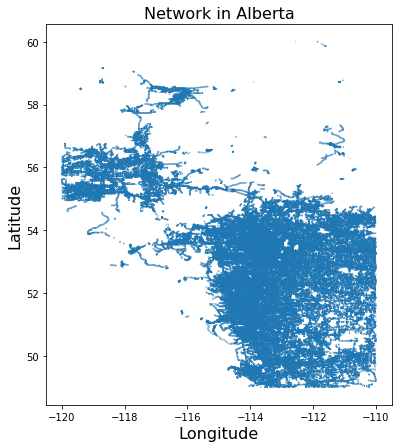

In [9]:
dfuse = pd.read_csv('albertaroads.csv')
dfuse['geometry'] = dfuse['geometry'].apply(wkt.loads)

dfuse = gpd.GeoDataFrame(dfuse, geometry='geometry')
ax = dfuse.plot(figsize=(9,7))
ax.set_xlabel("Longitude", size = 16)
ax.set_ylabel("Latitude", size = 16)
ax.set_title("Network in Alberta", size = 16)

This is never really used due to the choice of getting a heatmap instead, but here we are reading the shapefile for Alberta which includes the forward sortation area (first three letters of the postal code). We also go on to sort those further to see which network paths intersect with each individual linesegment. 

In [3]:
pcodes = gpd.read_file('lfsa000a16a_e.shp').to_crs(epsg=4326)
abcodes = pcodes[pcodes.PRNAME=='Alberta']

In [156]:
l = int(len(dfuse)/10000)
div = 10000
n = 0
testdf = pd.DataFrame()
for i in range(l+1):
    sub = dfuse.iloc[i*div:(i+1)*div]
    print('joining')
    d = gpd.sjoin(sub, abcodes, op='intersects')
    print(len(d) - div, "difference", i)
    testdf = testdf.append(d, ignore_index=True)

In [262]:
testdf.groupby("CFSAUID").sum().sort_values(by='Avail_50_1')

,NGDUID,Sub_ID,Avail_5_1_,Avail_10_2,Avail_25_5,Avail_50_1,index_right
CFSAUID,,,,,,,
T0V,187019228,14119916,0,0,0,0,49595
T6S,88876328,12082975,25,25,25,25,34925
T3S,579174925,51297707,148,148,139,33,238576
T1Z,255754994,21932443,55,55,55,39,87065
T5V,208929515,19813135,41,41,41,41,58794
...,...,...,...,...,...,...,...
T0A,182162044337,17124486242,44360,37645,28845,3211,64383067
T3H,15018277327,1305407055,3445,3409,3409,3397,4909125
T0E,93248147289,9255891330,23420,19550,18961,3477,34627584


In [85]:
testdf = pd.read_csv("networkswithpcodes.csv")

As the data is coded with binar yes/no if a network line can support a certain speed or not, this is a simple transformation to determine the maximum available speed on each segment. The idea being here is that if we want to see what is available for Albertans, it may be reasonable to assume they can get the maximum available in their particular region.

In [88]:
def max_avail(row):
    if row.Avail_50_1 == 1:
        return 50
    if row.Avail_25_5 == 1:
        return 25
    if row.Avail_10_2 == 1:
        return 10
    if row.Avail_5_1_ == 1:
        return 5
    else:
        return 0
testdf["max_speed"] = testdf.apply(max_avail, axis =1 )


In [87]:
testdf['geometry'] = testdf['geometry'].apply(wkt.loads)
testdf = gpd.GeoDataFrame(testdf, geometry='geometry')
testdf['points'] = testdf.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

Here we are converting each line segment to each of its lat/long coordinates so that we may make a heatmap. 

In [9]:

def pointsrtactor(df):
    pdict = {'lat':[], 'long':[], 'speed':[]}
    for row in df.iterrows():
        for tup in row[1]['points']:
            pdict['lat'].extend([tup[1]])
            pdict['long'].extend([tup[0]])
            pdict['speed'].extend([row[1]['max_speed']])
    return pd.DataFrame(pdict)
        
for_map = pointsrtactor(testdf)        
      

The function below will allow us to plot a particular segment of the data so we may observe the geospacial distribution of network speeds across Alberta. 

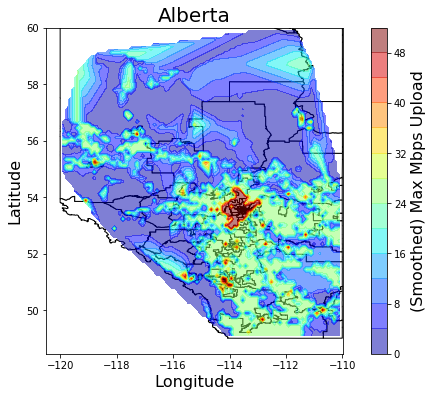

In [89]:
def make_plot(data, box = None, points=100, title=None, interp='linear'):

    if box:
        data = data[(data.lat > box['latmin']) & (data.lat < box['latmax']) &
                     (data.long > box['longmin']) & (data.long < box['longmax'])]

    fig, ax = plt.subplots(figsize=(10, 6))
    abcodes.plot(ax=ax, color='white', edgecolor='black')
   
    y = data['lat']
    x = data['long']
    z = data['speed']

    xi = np.linspace(x.min(), x.max(), points)
    yi = np.linspace(y.min(), y.max(), points)

    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method=interp, rescale=True)

    # CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k', vmin=0, vmax=50)
    CS = ax.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=0, vmax=50, alpha=.5)
    cbar = fig.colorbar(CS) # draw colorba
    cbar.set_label("(Smoothed) Max Mbps Upload", size = 16)
    ax.set_xlabel("Longitude", size = 16)
    ax.set_ylabel("Latitude", size = 16)
    if box:
        ax.set_xlim([box['longmin'], box['longmax']])
        ax.set_ylim([box['latmin'], box['latmax']])
    if title:
        ax.set_title(title, size = 20)
    
    plt.show()

make_plot(for_map, title='Alberta')


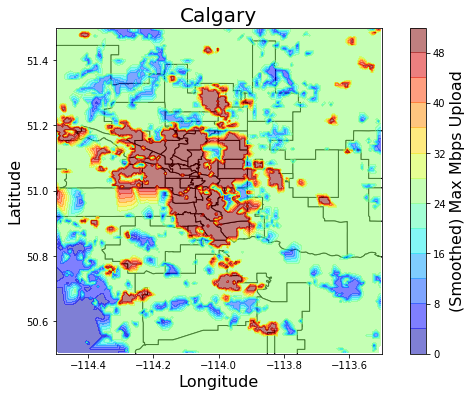

In [41]:
box = dict(latmin = 50.5, latmax = 51.5, longmin=-114.5, longmax=-113.5)
make_plot(for_map, box=box, points = 200, title = 'Calgary')


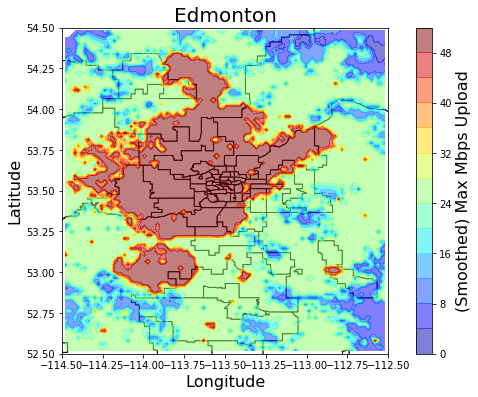

In [50]:
box = dict(latmin = 52.5, latmax = 54.5, longmin=-114.5, longmax=-112.5)
make_plot(for_map, box=box, points = 100, title = 'Edmonton')

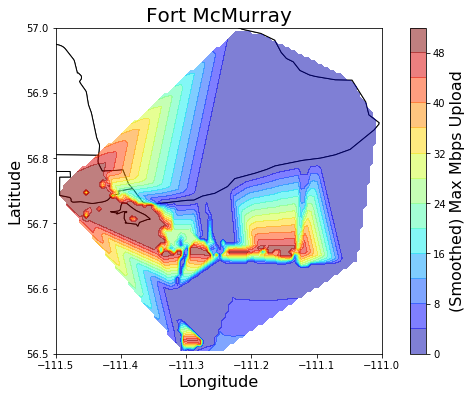

In [61]:
box = dict(latmin = 56.5, latmax = 57, longmin=-111.5, longmax=-111)
make_plot(for_map, box=box, points = 100, title= "Fort McMurray")

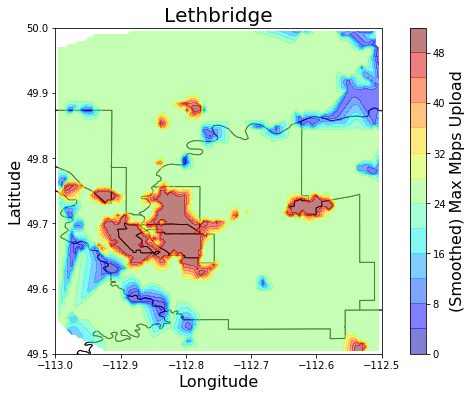

In [68]:
box = dict(latmin = 49.5, latmax = 50, longmin=-113, longmax=-112.5)
make_plot(for_map, box=box, points = 100, title= "Lethbridge")

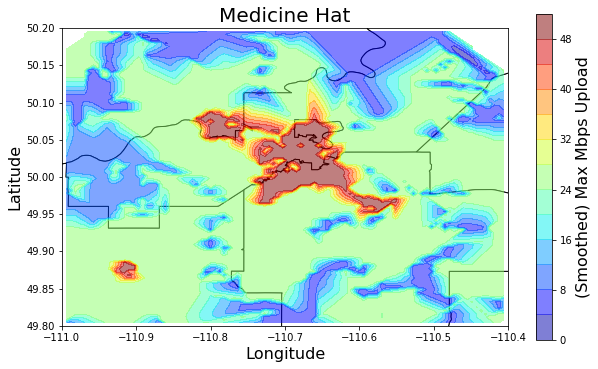

In [83]:
box = dict(latmin = 49.8, latmax = 50.2, longmin=-111.0, longmax=-110.4)
make_plot(for_map, box=box, points = 100, title= "Medicine Hat")